In [444]:

from pandas import read_csv, read_excel, crosstab

from scipy.stats import shapiro, kruskal, chi2_contingency

from numpy import sqrt

import statsmodels.api as sm

import statsmodels.formula.api as smf

from myFunctions import multiple_series_line_Chart

df = read_csv('../Data/CSV/csv_sifilis_moc_2019_2023.csv', sep=",", encoding='latin1', engine='python', thousands='.', decimal=',')

In [ ]:
df.head(5)

,Data_Notificacao,Ano,ID_MUNICIP,Unidade,DT_DIAG,Idade,TriGestacional,Raca,Escolaridade,Residencia,TPCONFIRMA,Tratamento,TPMOTPARC,TPESQPAR,TratamentoParceiro,CLASSI_FIN
0,1/8/2021,2021,314330,2219654,12/23/2020,22,3º,Parda,Ignorado,Urbana,1.0,Não realizado,Não Informado,5.0,2.0,1.0
1,2/6/2021,2021,314330,2219654,2/6/2021,17,3º,Parda,Ignorado,Urbana,3.0,PGB 7.200.000 UI,60,5.0,2.0,1.0


In [446]:

#Função para realização de análise associativa:
def chi_square_test(df, col1, col2):
    contingency_table = pd.crosstab(df[col1], df[col2])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"\nTeste Qui-Quadrado entre {col1} e {col2}:")
    print(f"Valor do Qui-Quadrado: {chi2:.2f}")
    print(f"p-valor: {p:.4f}")
    if p < 0.05:
        print("➡️ Rejeitamos H0: Existe associação significativa entre as variáveis.")
    else:
        print("➡️ Não há evidência estatística para associação significativa entre as variáveis.")


In [447]:

colunas_analise_associativa = ["Raca", "Escolaridade", "Residencia", "Tipo_teste"]

#### Gestantes Mais jovens são diagnosticadas mais tarde na gravidez?

In [448]:
# Verificando normalidade da idade dentro de cada trimestre
trimestres = df['TriGestacional'].unique()
grupo_idade = [df[df['TriGestacional'] == t]['Idade'] for t in trimestres]

# Teste de normalidade de Shapiro-Wilk (amostras pequenas) ou Kolmogorov-Smirnov (amostras grandes)
for i, t in enumerate(trimestres):
    stat, p = shapiro(grupo_idade[i])  # Se a amostra for grande, use kstest()
    print(f'Trimestre {t} - Teste de Normalidade Shapiro-Wilk: p = {p:.4f}')
    
# Se alguma distribuição não for normal, aplicamos Kruskal-Wallis
stat, p = kruskal(*grupo_idade)
print(f'Teste Kruskal-Wallis (idade vs trimestre gestacional): p = {p:.4f}')

Trimestre 3º - Teste de Normalidade Shapiro-Wilk: p = 0.0000
Trimestre 1º - Teste de Normalidade Shapiro-Wilk: p = 0.0000
Trimestre 2º - Teste de Normalidade Shapiro-Wilk: p = 0.0000
Trimestre Idade Gestacional Ignorada - Teste de Normalidade Shapiro-Wilk: p = 0.0000
Teste Kruskal-Wallis (idade vs trimestre gestacional): p = 0.6133


#### Há uma associação entre nível de escolaridade e o trimestre do diagnóstico?

In [449]:
# Criando a tabela de contingência
tab_escolar_trimestre = crosstab(df['TriGestacional'], df['Escolaridade'])

# Aplicando teste qui-quadrado
chi2, p, dof, expected = chi2_contingency(tab_escolar_trimestre)
print(f'Teste Qui-Quadrado (trimestre gestacional vs escolaridade): p = {p:.4f}')


Teste Qui-Quadrado (trimestre gestacional vs escolaridade): p = 0.0000


#### Há uma associação entre a raça e o trimestre do diagnóstico?

In [450]:

# Suponha que você já tenha a tabela de contingência tab_raca_trimestre
# Exemplo de tabela de contingência (substitua pelos seus dados reais)
tab_raca_trimestre = pd.crosstab(df['TriGestacional'], df['Raca'])

# Realizar o teste qui-quadrado para obter o valor de chi2
chi2, p, dof, expected = chi2_contingency(tab_raca_trimestre)
print(f'Teste Qui-Quadrado (trimestre gestacional vs raça): p = {p:.4f}')

# Calcular o V de Cramer
n = tab_raca_trimestre.sum().sum()  # Total de observações
k = min(tab_raca_trimestre.shape)  # Número mínimo de categorias (linhas ou colunas)
v_cramer = sqrt(chi2 / (n * (k - 1)))

# Exibir o resultado
print(f"V de Cramer: {v_cramer:.4f}")


Teste Qui-Quadrado (trimestre gestacional vs raça): p = 0.0416
V de Cramer: 0.1170


#### O esquema de tratamento varia dependendo do trimestre da gravidez?

In [451]:
# Criando a tabela de contingência
tab_trat_trimestre = crosstab(df['Tratamento'], df['TriGestacional'])

# Teste qui-quadrado
chi2, p, dof, expected = chi2_contingency(tab_trat_trimestre)

print(f'Teste Qui-Quadrado (Esquema de Tratamento x Trimestre Gestacional): p = {p:.4f}')

Teste Qui-Quadrado (Esquema de Tratamento x Trimestre Gestacional): p = 0.0006


#### O tratamento difere para gestantes mais jovens em comparação às mais velhas?

In [452]:
# Removendo valores nulos
df_clean = df.dropna(subset=['Idade', 'Tratamento'])

# Criando o modelo ANOVA
model = smf.ols("Idade ~ C(Tratamento)", data=df_clean).fit()
anova_table = sm.stats.anova_lm(model)

print("ANOVA: Esquema de Tratamento x Idade da Gestante")
print(anova_table)


from scipy.stats import kruskal

# Separar idades por grupo de tratamento
grupos = [df_clean[df_clean['Tratamento'] == grupo]['Idade'] for grupo in df_clean['Tratamento'].unique()]

# Aplicar o teste
estatistica, p_valor = kruskal(*grupos)
print(f"Teste de Kruskal-Wallis: p = {p_valor:.4f}")


ANOVA: Esquema de Tratamento x Idade da Gestante
                  df       sum_sq    mean_sq         F    PR(>F)
C(Tratamento)    5.0    171.75156  34.350312  0.971973  0.434133
Residual       619.0  21875.97004  35.340824       NaN       NaN
Teste de Kruskal-Wallis: p = 0.1452


                  count       mean       std   min   25%   50%    75%   max
Tratamento                                                                 
Ignorado           24.0  24.958333  5.606511  14.0  20.0  25.5  29.00  35.0
Não realizado      35.0  24.685714  5.068771  16.0  21.5  24.0  28.50  38.0
Outro esquema      69.0  23.594203  6.325297  15.0  19.0  22.0  26.00  42.0
PGB 2.400.000 UI  128.0  24.500000  6.037938  14.0  20.0  23.5  28.25  44.0
PGB 4.800.000 UI   33.0  23.727273  6.558738  17.0  19.0  22.0  25.00  41.0
PGB 7.200.000 UI  336.0  23.428571  5.872345  10.0  19.0  22.0  26.00  45.0


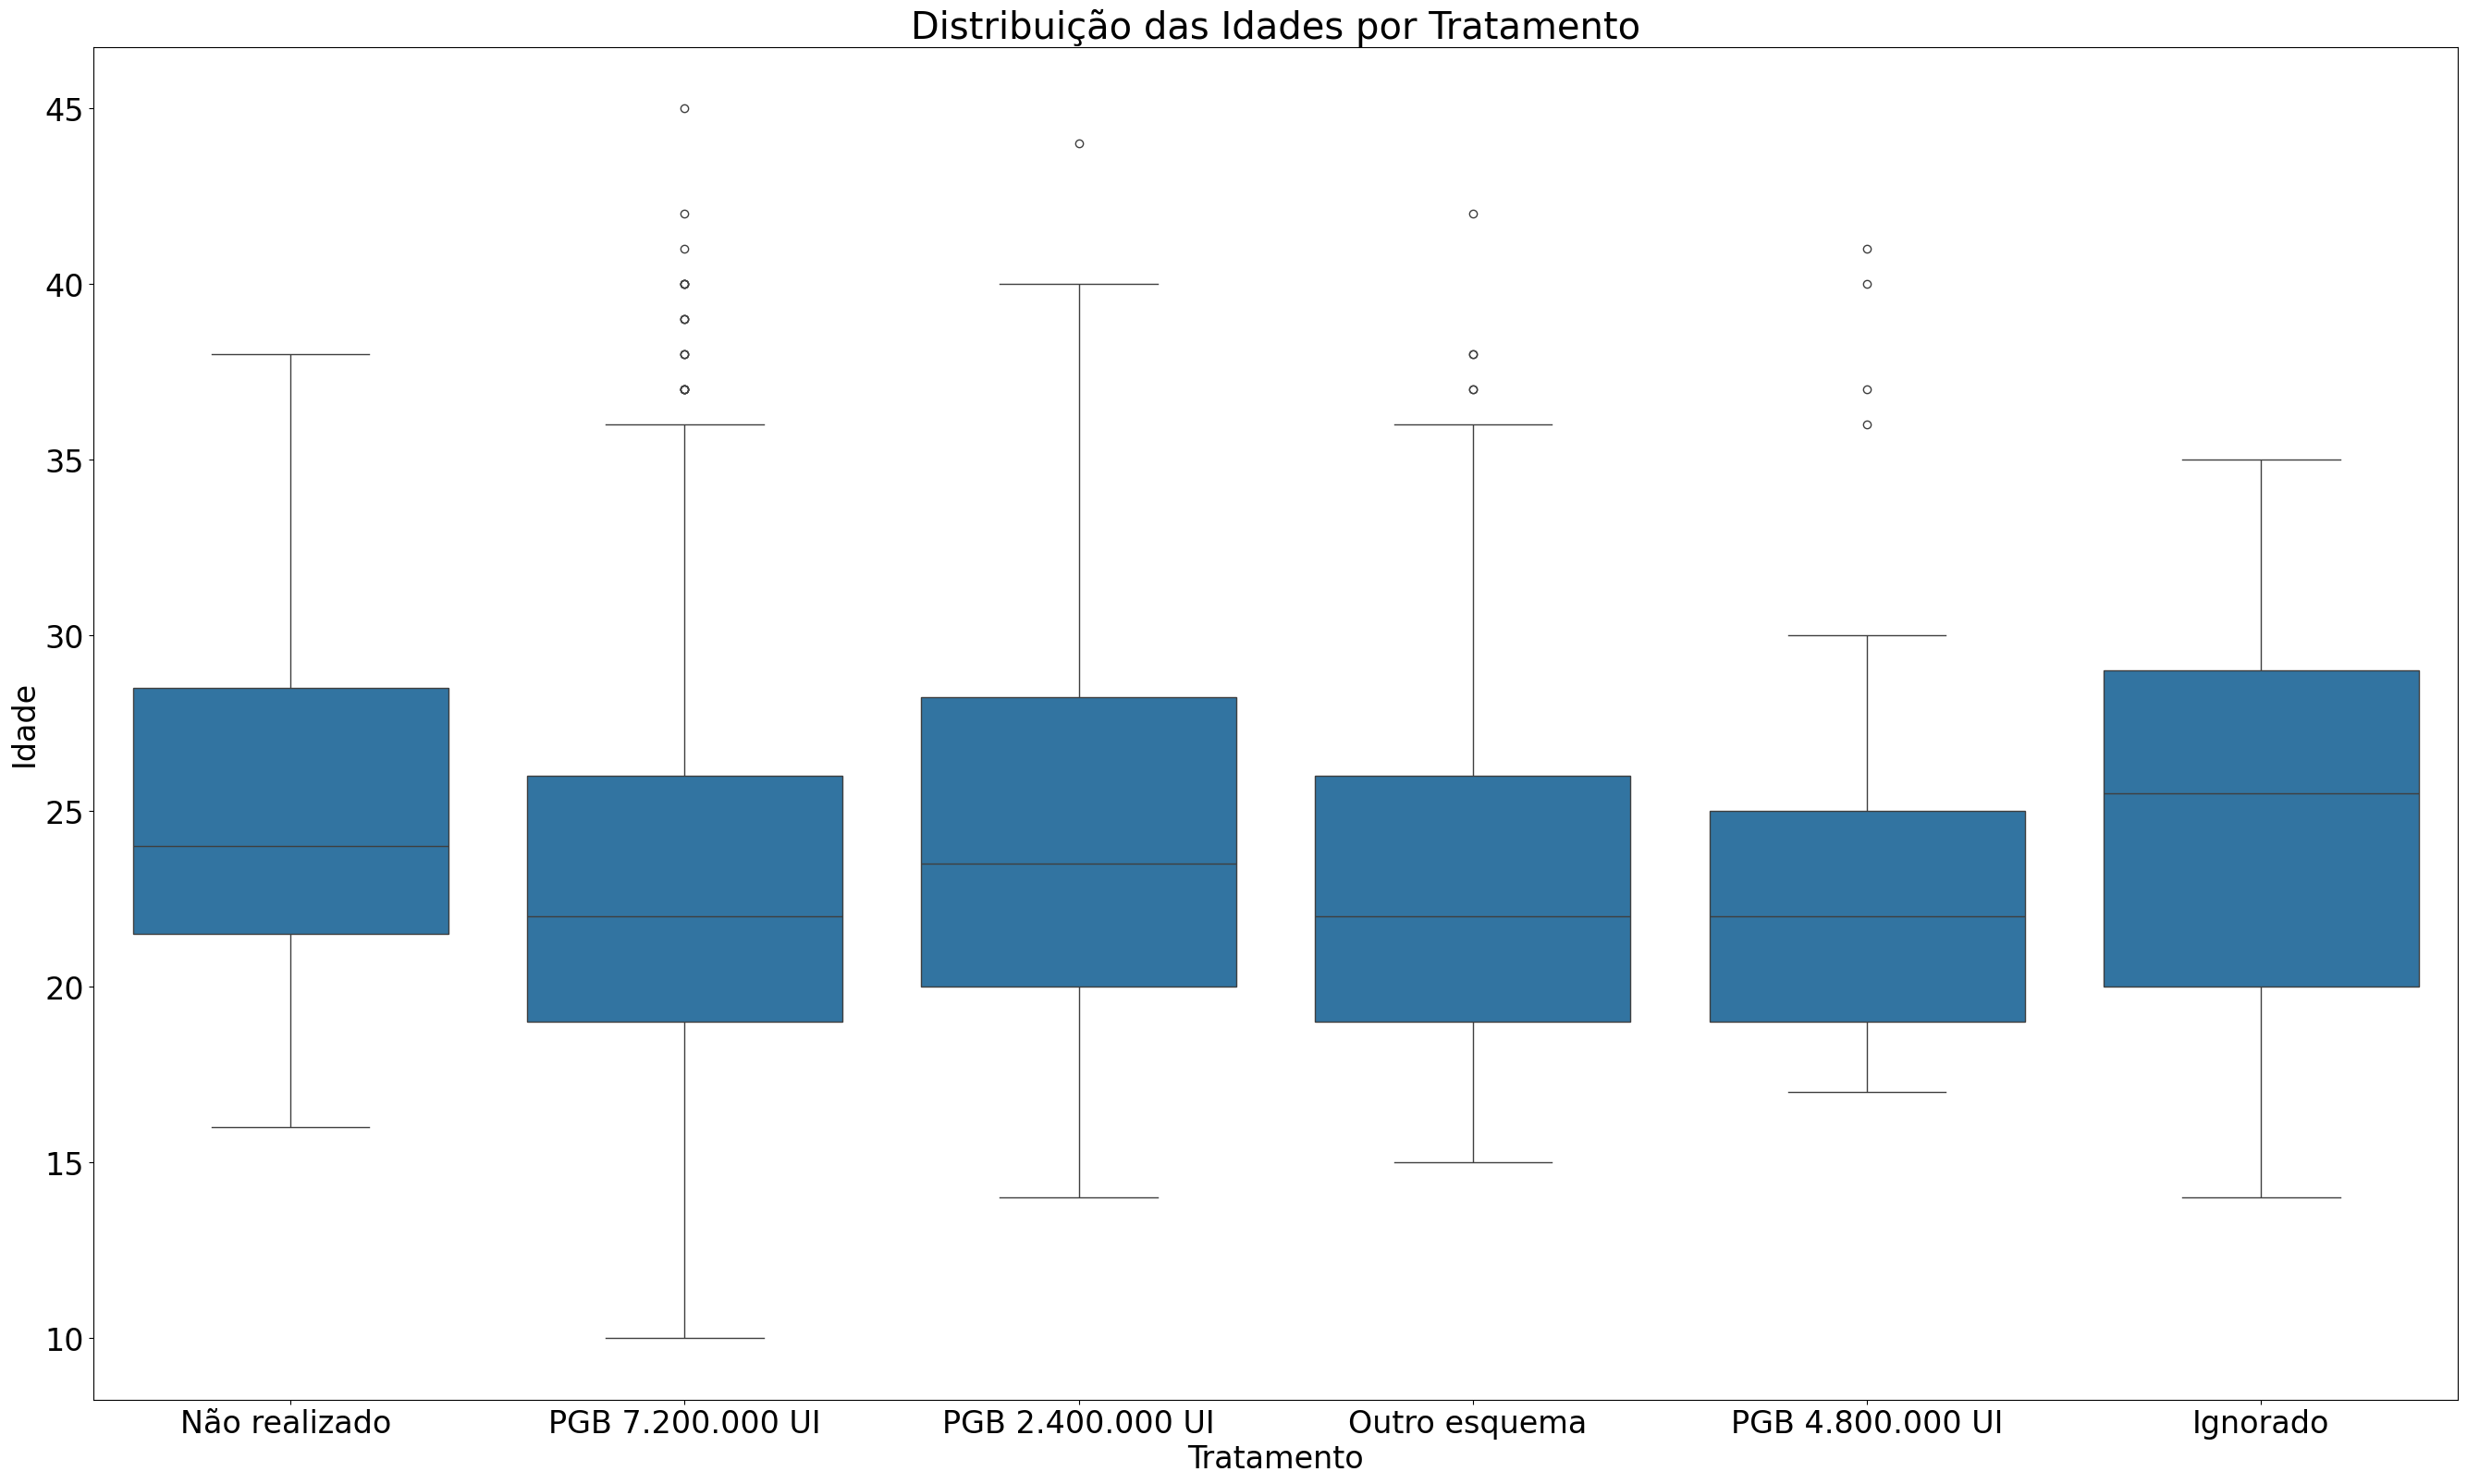

In [453]:
# Média e desvio padrão por tratamento
print(df_clean.groupby('Tratamento')['Idade'].describe())

# Boxplot das idades por tratamento
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(33, 19))
sns.boxplot(x='Tratamento', y='Idade', data=df_clean)
plt.title('Distribuição das Idades por Tratamento')
plt.show()
plt.rcParams.update({'font.size': 24})

                         count       mean       std   min   25%   50%   75%  \
Raca                                                                          
Amarela                    2.0  23.000000  9.899495  16.0  19.5  23.0  26.5   
Branca                    46.0  23.478261  5.714462  16.0  20.0  22.0  26.0   
Indígena                   1.0  31.000000       NaN  31.0  31.0  31.0  31.0   
Não Assinalado na Ficha  134.0  24.149254  6.705970  14.0  19.0  22.0  28.0   
Parda                    402.0  23.828358  5.695331  10.0  20.0  23.0  27.0   
Preta                     40.0  22.750000  5.934471  13.0  19.0  21.5  26.0   

                          max  
Raca                           
Amarela                  30.0  
Branca                   41.0  
Indígena                 31.0  
Não Assinalado na Ficha  45.0  
Parda                    42.0  
Preta                    44.0  


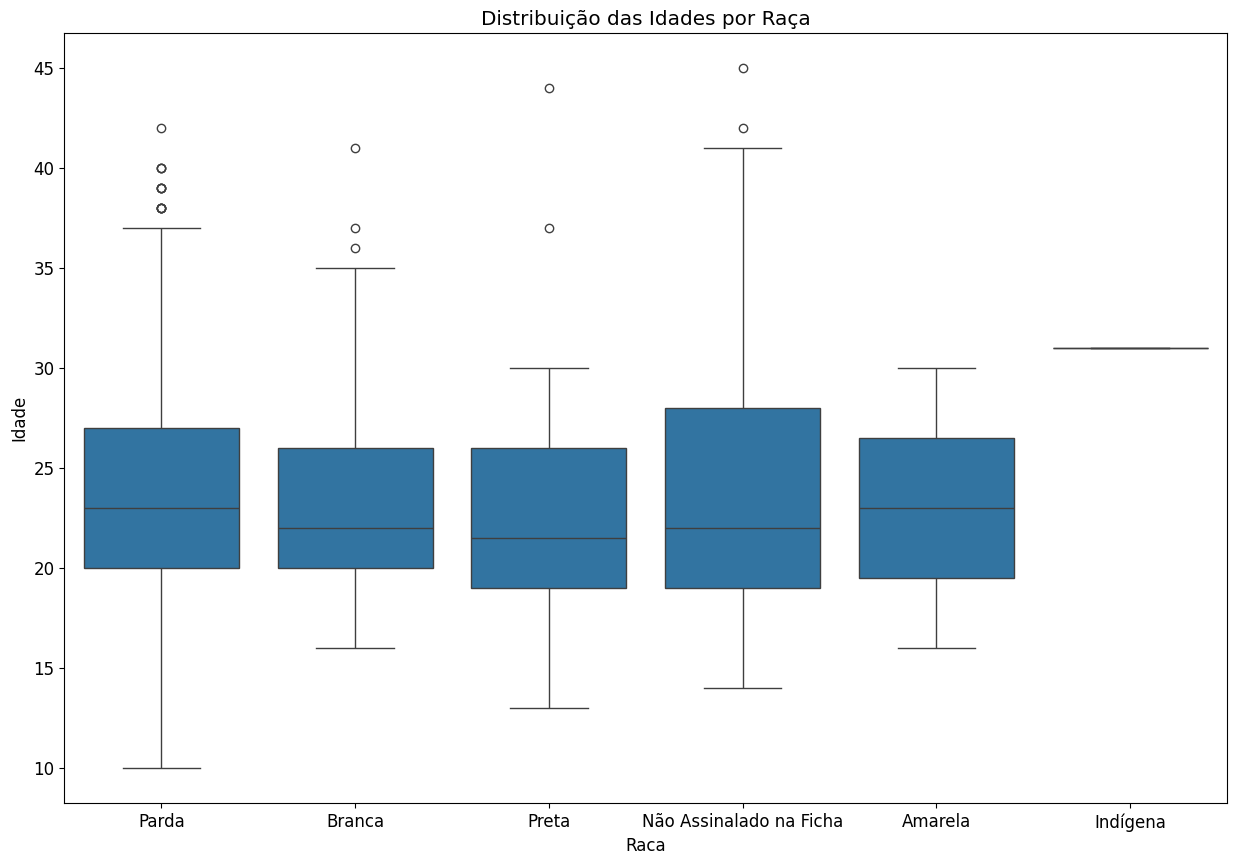

In [457]:
# Média e desvio padrão por tratamento
print(df_clean.groupby('Raca')['Idade'].describe())

# Boxplot das idades por tratamento
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
sns.boxplot(x='Raca', y='Idade', data=df_clean)
plt.title('Distribuição das Idades por Raça')
plt.show()
plt.rcParams.update({'font.size': 9})

                            count       mean       std   min   25%   50%  \
TriGestacional                                                             
1º                          143.0  24.097902  6.066898  14.0  20.0  23.0   
2º                           99.0  23.464646  6.186412  15.0  19.0  22.0   
3º                          267.0  23.823970  5.806636  11.0  20.0  23.0   
Idade Gestacional Ignorada  116.0  23.724138  5.954299  10.0  19.0  22.0   

                              75%   max  
TriGestacional                           
1º                          27.00  45.0  
2º                          25.50  41.0  
3º                          28.00  40.0  
Idade Gestacional Ignorada  26.25  44.0  


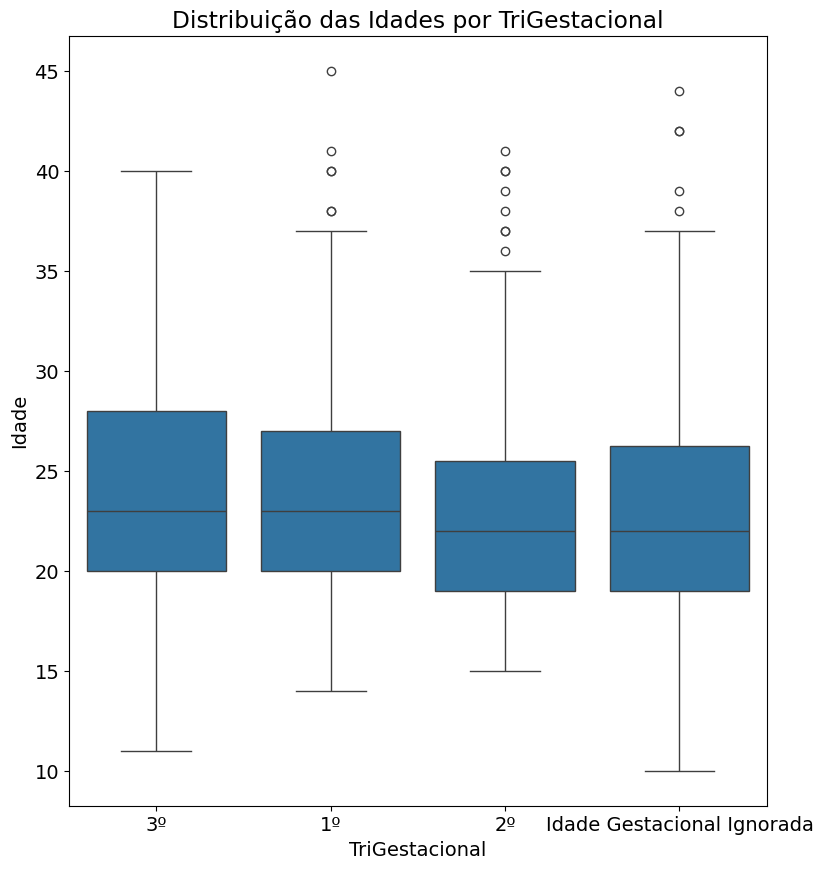

In [ ]:
# Média e desvio padrão por tratamento
print(df_clean.groupby('TriGestacional')['Idade'].describe())

# Boxplot das idades por TriGestacional
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.boxplot(x='TriGestacional', y='Idade', data=df_clean)
plt.title('Distribuição das Idades por TriGestacional')
plt.show()
plt.rcParams.update({'font.size': 14})